# Semi-Supervised Learning for Handwritten Digit Recognition

## Team
- Eric Li - ec2li@uwaterloo.ca
- Robert Liu - r436liu@uwaterloo.ca

## Abstract

This project explores the application of semi-supervised learning techniques to improve the classification accuracy of handwritten digits using the MNIST dataset with limited labeled data. A convolutional neural network is trained using a small set of labeled images, while a large set of unlabeled images is utilized to enhance the model's performance through the implementation of clustering, consistency regularization, and entropy minimization.

By combining these strategies, the project aims to achieve improved classification accuracy compared to solely relying on limited labeled data. Experimental results demonstrate the effectiveness of the model at decreasing levels of the number of labeled images (M = 6000, 2000, 1000, 500, 250, 50). The goal of this project is also to find the optimal number of labeled data is actually needed for the best accuracy to cost trade-off.

## Code Libraries

In [29]:
import numpy as np # Used for data manipulation and supports numerical computations
import random # Used for suffling data into label and unlabeled
import matplotlib.pyplot as plt # Used to create plots such as the accuracy and loss plots
import copy # Used to make deep copies of the model

import torch # Core library for PyTorch
import torch.nn as nn # Used to create neural network
import torch.optim as optim # Used to get optimization algorithms such as Adam which is used here
from torchvision import datasets, transforms # datasets is used to get the MNIST dataset which transform is for normalization of the data
import torch.nn.functional as F # Used for functions that are used for common neural network operation such as activation function or loss function.
from torch.utils.data import DataLoader, Subset #DataLoader is used to load the data for training and Subset is used for splitting the data into labeled and unlabeled sets


To install the libraries not in Anaconda, run: `pip install torch torchvision`

## Initial Model

### Hyperparameters

In [85]:
batch_size = 200
num_epochs = 50
M = 6000

We start with 6000 labeled images, which is 10% of the MNIST dataset. This provides us a baseline for comparison of our model.

### Data Handling

In [86]:
# Load the Data
DATASET_PATH = './data'
train_dataset = datasets.MNIST(root=DATASET_PATH, train=True, download=True)
test_dataset = datasets.MNIST(root=DATASET_PATH, train=False, download=True)

train_dataset_length = len(train_dataset)
test_dataset_length = len(test_dataset)

print(train_dataset_length)
print(test_dataset_length)

60000
10000


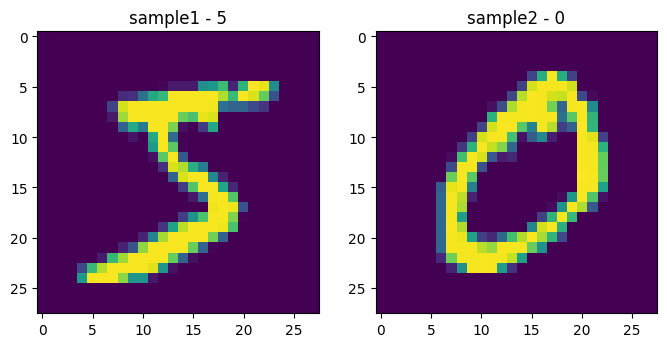

In [49]:
# Print sample data
img1, target1 = train_dataset[0]
img2, target2 = train_dataset[1]

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,2,1)
plt.title(f'sample1 - {target1}')
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
plt.title(f'sample2 - {target2}')
ax2.imshow(img2)

In [87]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1306,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1306,), (0.3081,))
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

These data augmentations are used to transform the data into tensors which can be fed into the neural network, and then normalize it to standardize the pixel values using the mean of 0.1306 and the standard deviation 0.3081. These values were obtained from online sources (https://mint.westdri.ca/ai/pt/pt_mnist).

In [88]:
# Split labeled and unlabeled data
def split_data(train_dataset, test_dataset, M):
  indices = list(range(len(train_dataset)))
  random.shuffle(indices)
  labeled_indices = indices[:M]
  unlabeled_indices = indices[M:]

  labeled_subset = Subset(train_dataset, labeled_indices)
  unlabeled_subset = Subset(train_dataset, unlabeled_indices)

  labeled_loader = DataLoader(labeled_subset, batch_size=batch_size, shuffle=True)
  unlabeled_loader = DataLoader(unlabeled_subset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  return labeled_loader, unlabeled_loader, test_loader

labeled_loader, unlabeled_loader, test_loader = split_data(train_dataset, test_dataset, M)

We split the data based on the number of labeled images M to create the data loaders for the neural network.

### CNN Model Design

In [84]:
# Design the classification network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 3 * 3, 300),
            nn.ReLU(),
            nn.Linear(300, 10)
        )

    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        return self.classifier(f), f


The model is comprised of three convolutional layers with ReLU activation and two max-pooling layers, used for extracting features from the input image. The output of the features part is then flattened and fed into the classifier, a network with two linear layers and a ReLU activation in between. In the final layer, we output 10 nodes, one for each digit.

The forward method takes an input image, extracts its features, flattens it, and passes it through the classifier to produce the predictions. It returns the extracted features and the classification output.

### Training Loop

In [ ]:
# Hyperparameters
lr = 0.001
lambda_cluster = 0.1
lambda_consistency = 0.5
lambda_entropy = 0.05

# Loss functions
def clustering_loss(features, centroids):
    distances = torch.cdist(features, centroids)
    return distances.min(dim=1)[0].mean()

def consistency_loss(logits1, logits2):
    return F.mse_loss(logits1.softmax(dim=1), logits2.softmax(dim=1))

def entropy_loss(logits):
    probs = F.softmax(logits, dim=1)
    return torch.mean(torch.sum(probs * torch.log(probs + 1e-8), dim=1))

# Training loop
def train(model, labeled_loader, unlabeled_loader, test_loader, optimizer, num_epochs, log_validation = True):

  acc = 0
  loss_history = []
  acc_history = []

  for epoch in range(num_epochs):
      model.train()
      total_loss = 0

      # Calculate centroids using labeled data
      with torch.no_grad():
          all_features = []
          all_labels = []
          for x, y in labeled_loader:
              _, features = model(x)
              all_features.append(features)
              all_labels.append(y)
          features = torch.cat(all_features)
          labels = torch.cat(all_labels)
          centroids = torch.stack([features[labels == i].mean(0) for i in range(10)])

      # Training batches
      for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):
          optimizer.zero_grad()

          # Labeled data
          logits_l, features_l = model(x_l)
          loss_ce = F.cross_entropy(logits_l, y_l)

          # Unlabeled data
          x_u_aug = transforms.functional.affine(x_u, angle=15, translate=(0.1,0.1), scale=0.9, shear=10)
          logits_u, features_u = model(x_u)
          logits_u_aug, _ = model(x_u_aug)

          # Cluster loss
          loss_cluster = clustering_loss(features_u, centroids)

          # Consistency loss
          loss_consistency = consistency_loss(logits_u, logits_u_aug)

          # Entropy loss
          loss_entropy = entropy_loss(logits_u)

          # Total loss
          loss = (loss_ce +
                  lambda_cluster * loss_cluster +
                  lambda_consistency * loss_consistency +
                  lambda_entropy * loss_entropy)

          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if not log_validation:
        continue
      
      # Validation with in the epoch
      correct = 0
      if (epoch+1) % 5 == 0 or epoch == 0:
        model.eval()
        correct = 0
        with torch.no_grad():
            for x, y in test_loader:
                logits, _ = model(x)
                pred = logits.argmax(dim=1)
                correct += pred.eq(y).sum().item()
        acc = 100. * correct / len(test_loader.dataset)
        acc_history.append(acc)
        print(f'Epoch {epoch+1}: Loss: {total_loss/len(labeled_loader):.4f}, Acc: {acc:.2f}%')

      loss_history.append(total_loss/len(labeled_loader))

  if log_validation:
    # Plot the loss graph after training
    plt.figure(figsize=(6, 6))
    plt.plot(range(1, num_epochs+1), loss_history, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

    # Plot the accuracy graph after training
    plt.figure(figsize=(6, 6))
    plt.plot(acc_history, marker='o')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.show()

The clustering loss computes the average minimum distance between each sample's features and the centroids. We use clustering loss since lower average minimum distances imply that features are clustered more tightly around their nearest clusters which implies better well-defined clusters which mean that it pulls unlabeled data toward the closest centroid.

The consistency loss computes the difference between the predictions for an image and an augmented one. We want to lower this to push for the model to produce similar outputs for sightly modified output.

The entropy loss computes the softmax probabilities of the logits and computes the entropy. When we minimize this loss, we encourage the model to make confident predictions on unlabeled data by reducing the uncertainty.


Now, for the training loop, each epoch starts by putting the model into training model, calculating centroids using PyTorch using the labeled data. The goal of this step is set reference points for each digit. For each epoch, the loop process one batch of labeled with a batch unlabeled data at the same time. For labeled data, it does computes the cross-entropy loss between the model outputs and the true label. For unlabeled data, we first compute an affine transformation of the image for the consistency loss. Then, the unlabeled data with its affine transformation is fed to 3 loss functions mentioned above for reasons explained above. The total loss is then a weighted sum of the 4 losses (1 from supervised and 3 for unsupervised).

After the loss is computed, the optimizer backprogates and updates the model parameters. After every 5 epoch, if the option is selected, the model switches to evaluation mode to compute the accuracy of the over the test dataset. We compure the predicted to the actual label. We finally print out the loss and the accuracy for the epoch. The accuracy can be used to determine when the model is at its best for prediction compared to when it overfits on the data.

### Validation Loop

In [80]:
def confusion_matrix(preds, targets, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, targets):
        conf_matrix[p, t] += 1

def validate(val_loader, net, fig_num=0, criterion = F.nll_loss):

    conf_matrix = torch.zeros(10, 10)

    iou_arr = []

    net.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for i, data in enumerate(val_loader):

            inputs, target = data

            # Get only the logits (first element of the output tuple)
            output, _ = net(inputs)

            # Apply log_softmax before calculating NLL loss
            output = F.log_softmax(output, dim=1)

            val_loss += criterion(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            confusion_matrix(output, target, conf_matrix)

    val_loss /= len(val_loader.dataset)

    if fig_num>0:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))

        plt.figure(fig_num,figsize=(5,3))
        plt.title('Confusion Matrix')
        plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.xticks(np.arange(10), labels, rotation='vertical')
        plt.yticks(np.arange(10), labels)
        plt.show()

    net.train()
    return correct / len(val_loader.dataset)

The code for this validation loop is heavily inspired on the validation loop from the classification notebook from the course website. It gives the average loss, the accuracy percentage, and the confusion matrix which can all be used to determine how good is the model on the testing dataset which the model has not been trained on.

### Training the Initial Model

Epoch 1: Loss: 1.9411, Acc: 83.52%
Epoch 5: Loss: 0.2808, Acc: 97.33%
Epoch 10: Loss: 0.1613, Acc: 98.12%
Epoch 15: Loss: 0.1096, Acc: 98.28%


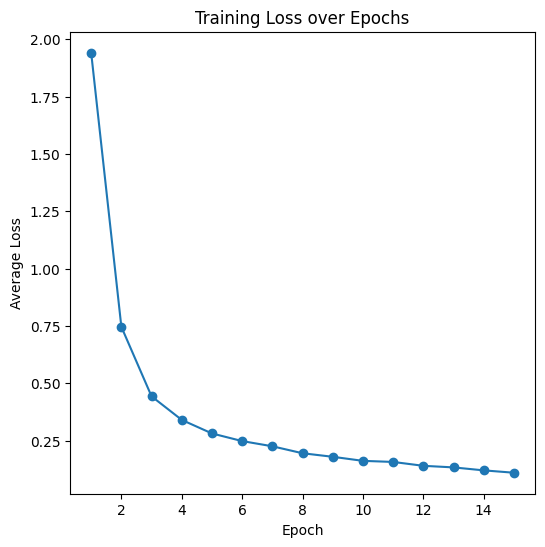

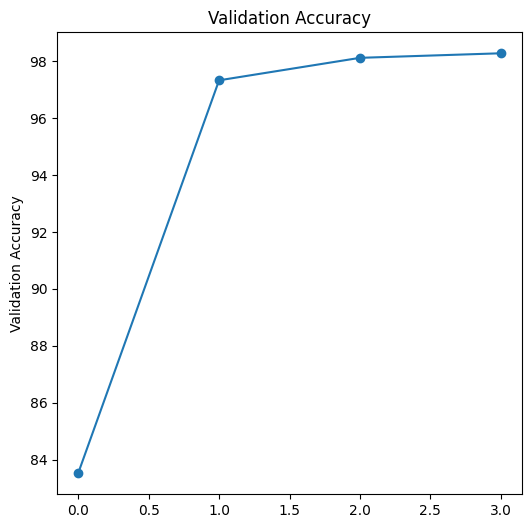

In [91]:
untrained_net = MyNet()
training_net = copy.deepcopy(untrained_net)
optimizer = torch.optim.Adam(training_net.parameters(), lr=lr)
train(training_net, labeled_loader, unlabeled_loader, test_loader, optimizer, 15)

This is the result of the training loop for the initial model which has 6000 labeled data. 6000 labeled data is 10% of the MNIST training dataset.

As we see from the first graph, the average loss decreases consistently over the epochs. Initially, this decrease was fast, indicating significant improvements in the model's ability to fit the training data. As training progressed, the rate of this decrease slowed down gradually. This suggests that improvements were increasingly marginal, which is typical for this kind of graph.

The second graph shows the accuracy of the model over time. Once again, we note that the more major jumps in accuracy happen early on, and that they start to slow down as the training progresses. At the end of the training, in epoch 15, we see that the validation accuracy stabilizes at around 98%.

### Untrained vs Trained Model Evaluation


Test set: Average loss: 2.3059, Accuracy: 997/10000 (10%)



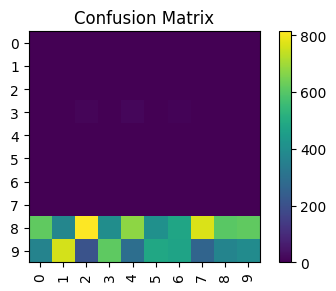

0.0997

In [65]:
# Evaluate the model
validate(test_loader, untrained_net, 4)

The untrained model has a validation accuracy of around 10%, which is expected, since it is the same as a random guess of 1 digit among 10 digits.

We observe from the confusion matrix that it tends to only predict 8 and 9.


Test set: Average loss: 0.0622, Accuracy: 9828/10000 (98%)



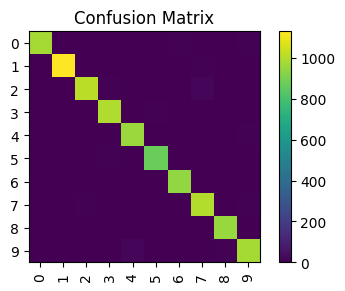

0.9828

In [92]:
# Evaluate the model
validate(test_loader, training_net, 4)

The trained model has an accuracy of around 98% on testing data, which is good considering we only used 10% labeled data and 90% unlabeled data.

From the confusion matrix, we can see that the model accurately predicts the right digit for test digits 0 through 9, with very few mistakes, notable ones being guessing 2 on a 7 and guessing 9 on a 4.

### Comparing Both Models with Sample Data

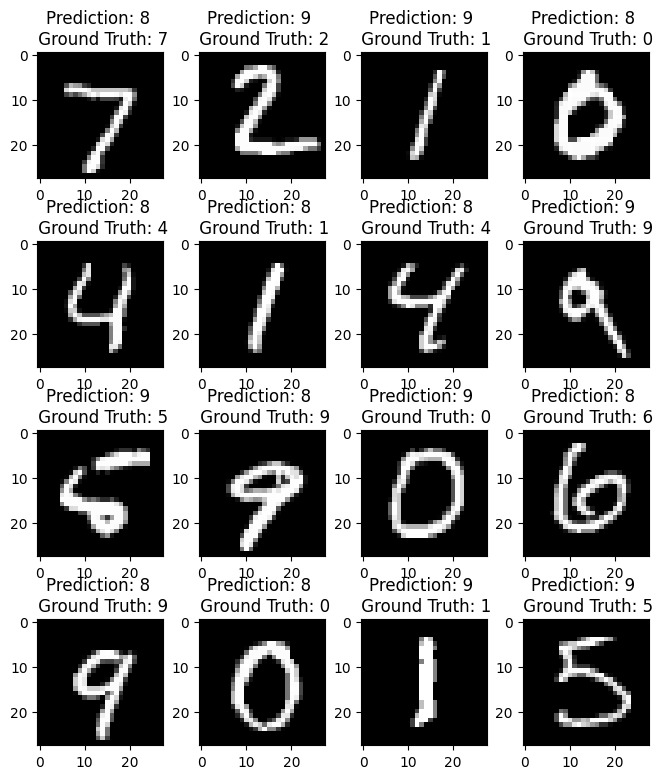

In [68]:
# Plot example for untrained model
labels = list(range(10))

fig = plt.figure(3, figsize=(8,9))
plt.subplots_adjust(hspace=0.5)

for i in range(16):
    sample_img, sample_target = test_dataset[i]
    sample_output, _ = untrained_net(sample_img.unsqueeze(0))
    pred = int(torch.argmax(sample_output, dim=1).item())

    ax1 = fig.add_subplot(4, 4, i+1)
    plt.title("Prediction: {} \n Ground Truth: {}".format(
        labels[pred],
        labels[int(sample_target)]
    ))

    ax1.imshow(sample_img.squeeze().cpu().numpy(), cmap="gray")

plt.show()

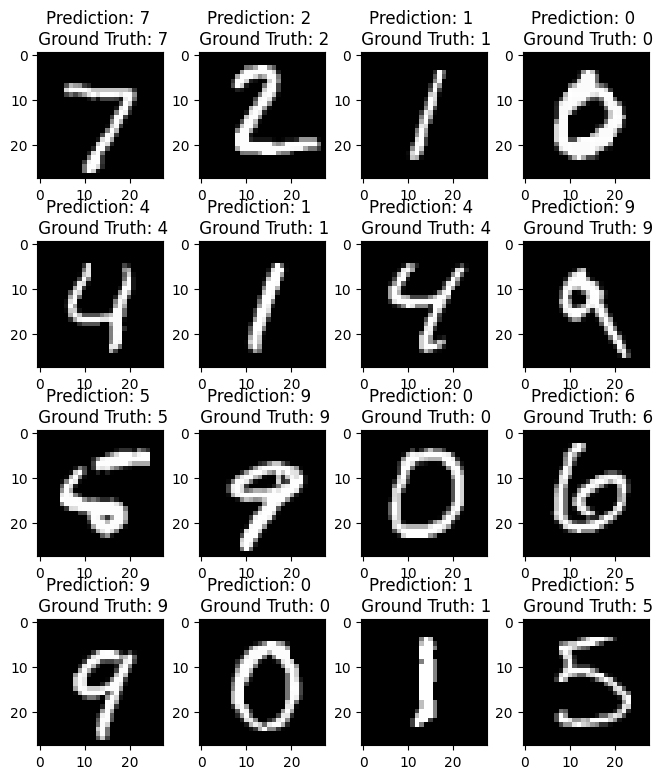

In [69]:
# Plot example for trained model
labels = list(range(10))


fig = plt.figure(3, figsize=(8,9))
plt.subplots_adjust(hspace=0.5)

for i in range(16):
    sample_img, sample_target = test_dataset[i]
    sample_output, _ = training_net(sample_img.unsqueeze(0))
    pred = int(torch.argmax(sample_output, dim=1).item())

    ax1 = fig.add_subplot(4, 4, i+1)
    plt.title("Prediction: {} \n Ground Truth: {}".format(
        labels[pred],
        labels[int(sample_target)]
    ))

    ax1.imshow(sample_img.squeeze().cpu().numpy(), cmap="gray")

plt.show()

From these 16 examples from the testing dataset we see that the model predicts the right data on each digit.

## Testing the Model at decreasing M

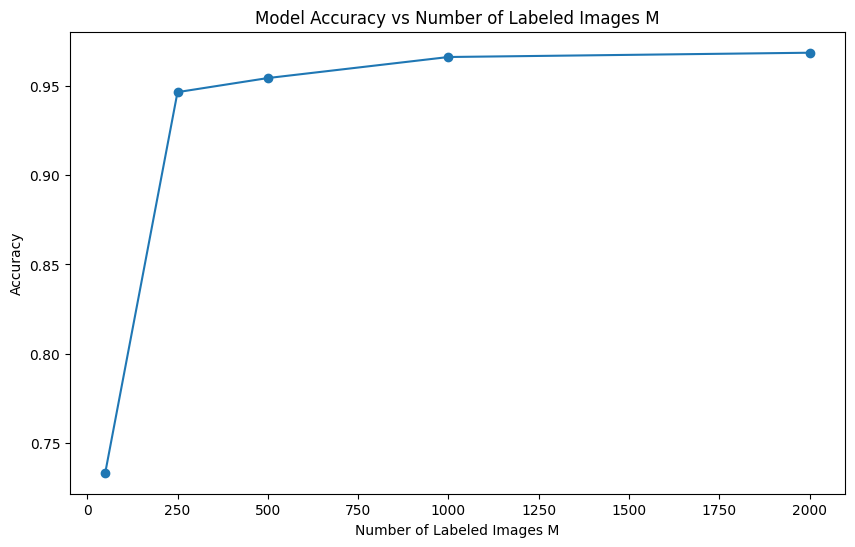

In [70]:
M_values = [2000, 1000, 500, 250, 50]
models = []
accuracies = []


for M in M_values:
  # print(f"Training model with M = {M}")

  labeled_loader, unlabeled_loader, test_loader = split_data(train_dataset, test_dataset, M)

  # Training
  training_net = copy.deepcopy(untrained_net)
  optimizer = torch.optim.Adam(training_net.parameters(), lr=lr)
  train(training_net, labeled_loader, unlabeled_loader, test_loader, optimizer, num_epochs, log_validation=False)
  models.append(training_net)

  # Evaluating
  accuracy = validate(test_loader, training_net)
  accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(M_values, accuracies, marker='o')
plt.xlabel('Number of Labeled Images M')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Number of Labeled Images M')
plt.show()


The above plot shows the accuracy of the model at other numbers of labeled images, namely 50 (0.08% of the dataset), 250 (0.4%), 500 (0.8%), 1000 (1.7%) and 2000 (3.3%). We observe that the lowest accuracy is the model trained on 50 labeled images, and that the accuracy has a large increase at 250 labeled images, and the accuracy gains slow down as the number of labeled images increases.

Judging from this plot, for our model, a number of labeled images of 1000 is a solid middle ground between the accuracy of the model and its cost. Indeed, doubling the number of labeled images from 1000 does not contribute significant gains to the accuracy.

## Conclusion

This project demonstrated the use case of semi-supervised learning for handwritten digit classification using the MNIST dataset. We achieve thing by combining a convolutional neural network with clustering, consistency regularization, and entropy minimization. This is done by combining the loss function of the CNN with the 3 loss functions using a weighted sum.

The results from the testing, the accuracy percentage, the confusion matrices and image predictions, show the efficacy of our approach in using unlabeled data to enhance model performance. With only 10% of the data labeled, we were able to obtain an accuracy of 98%. With less of 1% of the data labeled, we can obtain 95% plus accuracy. Future work could explore different type of clustering algorithms, different regularization strategies, and network architectures to further improve the accuracy, the robustness, and the cost of training of the model.